 Подключаем все необходимые библиотеки

In [169]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas 
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn.model_selection import train_test_split
from haversine import haversine, Unit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

Получаем датафрейм и проверяем, нет ли там пропусков:

In [170]:
data = pandas.read_csv("train.csv")
data.columns
pandas.isnull(data).any()


id                    False
vendor_id             False
pickup_datetime       False
dropoff_datetime      False
passenger_count       False
pickup_longitude      False
pickup_latitude       False
dropoff_longitude     False
dropoff_latitude      False
store_and_fwd_flag    False
trip_duration         False
dtype: bool

In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1021050 non-null  object 
 1   vendor_id           1021050 non-null  int64  
 2   pickup_datetime     1021050 non-null  object 
 3   dropoff_datetime    1021050 non-null  object 
 4   passenger_count     1021050 non-null  int64  
 5   pickup_longitude    1021050 non-null  float64
 6   pickup_latitude     1021050 non-null  float64
 7   dropoff_longitude   1021050 non-null  float64
 8   dropoff_latitude    1021050 non-null  float64
 9   store_and_fwd_flag  1021050 non-null  object 
 10  trip_duration       1021050 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 85.7+ MB


In [172]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,N,844
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,N,1001
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,N,1048
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,N,732


In [173]:
test = pandas.read_csv("test.csv")
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

Заметим, что в тестовых данных нет столбца "dropoff_datetime", поэтому можем сразу убрать этот показатель из нашего датафрейма. 


In [174]:
data = data.drop(columns="dropoff_datetime")

Построим гистограмму для продолжительности поездок для того, чтобы понять характер распределния продолжительности поездки:

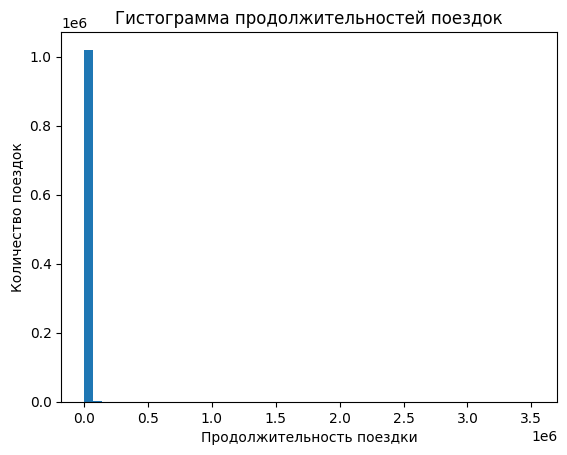

In [175]:
plt.hist(data["trip_duration"], bins=50)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Мы видим, что гистограмма получилась не показательной из-за вбросов, избавимся от них:

In [176]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06
mean,1.535298e+00,1.663364e+00,-7.397347e+01,4.075093e+01,-7.397339e+01,4.075180e+01,9.617193e+02
std,4.987527e-01,1.312695e+00,6.453953e-02,3.347413e-02,6.416123e-02,3.581601e-02,5.900133e+03
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073734e+01,-7.399132e+01,4.073587e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075410e+01,-7.397975e+01,4.075453e+01,6.630000e+02
75%,2.000000e+00,2.000000e+00,-7.396734e+01,4.076834e+01,-7.396303e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [177]:
lower_limit = data["trip_duration"].quantile(0.01)
upper_limit = data["trip_duration"].quantile(0.975)
data = data[(data["trip_duration"] >= lower_limit) & (data["trip_duration"] <= upper_limit)]


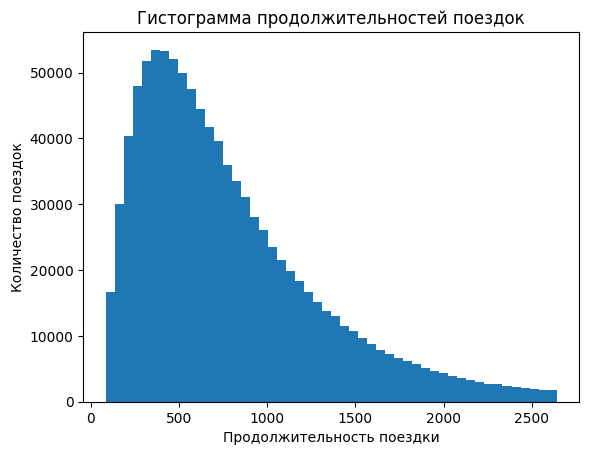

In [178]:
plt.hist(data["trip_duration"], bins=50)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Мы видим, что гистограмма отдалённо похожа на плотность нормального распределения, однако она смещена влево и не симметрична, постараемся привести её в более правильную форму, прологарифмировав время поездки:


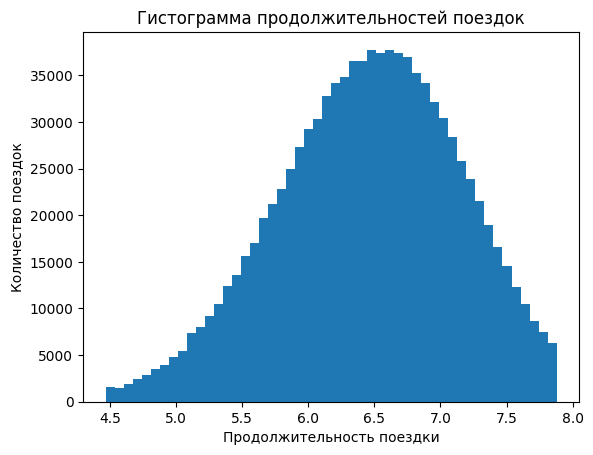

In [179]:
data["trip_duration"] = np.log(data['trip_duration'] + 1)
plt.hist(data["trip_duration"], bins=50)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Далее проанализируем данные параметры, для этого мы можем просто взять среднее значение длительности поездки для каждого параметра, построить соответствующие графики и по ним, а также по другим показателям определить, стоит ли использовать данный параметр для обучения модели:

# vendor_id


,vendor_id,trip_duration
0,1,6.447200
1,2,6.451006


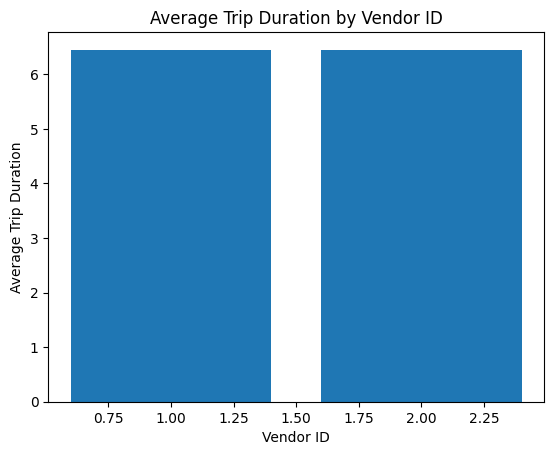

In [180]:
meanVendorId = (data.groupby('vendor_id')['trip_duration']).mean().reset_index()
plt.xlabel("Vendor ID")
plt.ylabel("Average Trip Duration")
plt.title("Average Trip Duration by Vendor ID")
plt.bar(meanVendorId["vendor_id"], meanVendorId["trip_duration"])
meanVendorId

Во-первых, как видно из графика, от конкретного поставщика продолжительность поездки не меняется, во-вторых, мы вообще ничего не знаем о конкретных поставщиках, поэтому никакой дополнительной информации из этих данных для модели мы достать не сможем, следовательно, данный параметр для обучения модели брать мы не будем, так как он не коррелирует с таргетом.

In [181]:
data = data.drop(columns="vendor_id")

# passenger_count

,passenger_count,trip_duration
0,0,6.228577
1,1,6.439513
2,2,6.480417
3,3,6.486009
4,4,6.491498
5,5,6.452605
6,6,6.446584
7,8,4.653960
8,9,6.329721


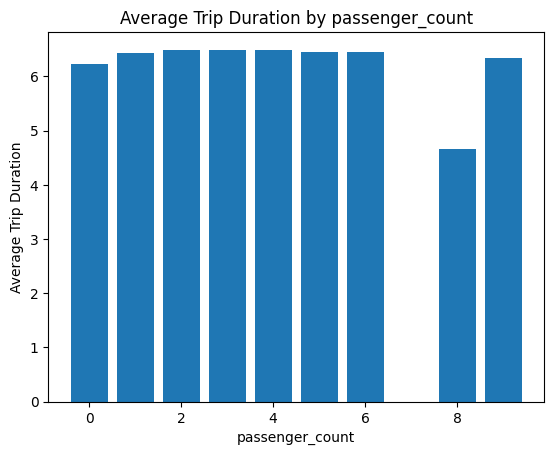

In [182]:
meanPassengerCount = (data.groupby('passenger_count')['trip_duration']).mean().reset_index()
plt.xlabel("passenger_count")
plt.ylabel("Average Trip Duration")
plt.title("Average Trip Duration by passenger_count")
plt.bar(meanPassengerCount["passenger_count"], meanPassengerCount["trip_duration"])
meanPassengerCount

Мы видим, менее продолжительные поездки, в которых участвуют 8 пассажиров, мы можем взять этот параметр для нашей модели, но для пущей точности мы еще должны посмотреть, сколько было поездок ввосьмером, чтобы понять, какой характер они имеют: постоянный или это больше исключение:

In [183]:
sizePassengerCount = (data.groupby('passenger_count')).size().reset_index()
sizePassengerCount

,passenger_count,0
0,0,11
1,1,699085
2,2,141781
3,3,40444
4,4,18988
5,5,52656
6,6,32546
7,8,1
8,9,1


Как мы видим, поездка ввосьмером была всего одна, поэтому она не является показательной, следовательно мы не видим зависимость между количеством пассажиров и длительностью поездки.

In [184]:
data = data.drop(columns="passenger_count")

# store_and_fwd_flag

Переведём этот показатель в численные значения: Y - 1, N - 0;

In [185]:
data['store_and_fwd'] = data['store_and_fwd_flag'].apply(lambda x: 1 if x == 'Y' else 0)
data = data.drop(columns="store_and_fwd_flag")


,store_and_fwd,trip_duration
0,0,6.448457
1,1,6.597399


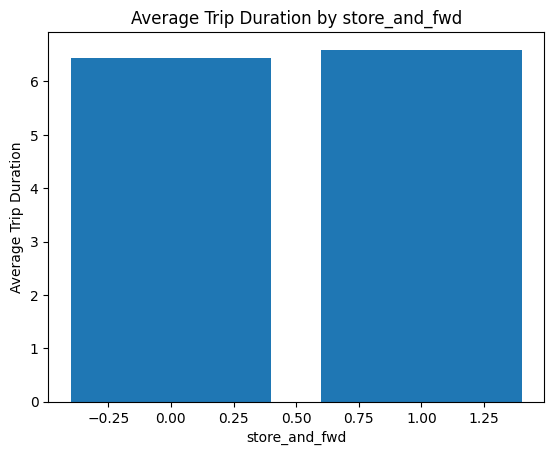

In [186]:
meanStoreAndatawd = (data.groupby('store_and_fwd')['trip_duration']).mean().reset_index()
plt.xlabel("store_and_fwd")
plt.ylabel("Average Trip Duration")
plt.title("Average Trip Duration by store_and_fwd")
plt.bar(meanStoreAndatawd["store_and_fwd"], meanStoreAndatawd["trip_duration"])
meanStoreAndatawd

Мы видим, что данный параметр никак не влияет на продолжительность поездки, поэтому его мы тоже убираем:

In [187]:
data = data.drop(columns="store_and_fwd")
data

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,id2209155,2016-05-03 09:03:08,-73.979813,40.752529,-73.982681,40.763680,6.739337
1,id0586605,2016-01-01 16:40:51,-73.977623,40.746296,-73.968414,40.788933,6.909753
2,id0467144,2016-04-24 13:57:03,-73.950699,40.779404,-73.863129,40.768608,6.955593
3,id0989010,2016-01-10 17:03:47,-73.984558,40.721802,-73.976753,40.752213,6.665684
4,id0580742,2016-02-25 17:37:36,-73.967720,40.768742,-73.977173,40.789875,6.597146
...,...,...,...,...,...,...,...
1021045,id1753868,2016-03-25 07:11:49,-73.955032,40.777328,-74.006203,40.749424,7.156177
1021046,id2204747,2016-02-16 18:01:45,-73.973618,40.763920,-73.983849,40.749874,6.726233
1021047,id3043606,2016-01-26 19:22:29,-74.006195,40.734283,-73.949608,40.785282,7.159292
1021048,id1458584,2016-01-19 11:53:47,-73.962341,40.767323,-73.969757,40.768669,5.966147


# Анализ оставшихся параметров

У нас осталось всего 5 параметров:
1. Время  и дата поездки;
2. Широта начала поездки;
3. Долгота начала поездки;
4. Широта конца поездки;
5. Долгота конца поездки;

# pickup_datetime

Данные в таком формате мало что дают для нашей модели, поэтому этот столбец придется разбить на:
- месяц;
- время суток;
- день недели;

# Месяц

Так как месяц - категориальная величина, я воспользуюсь простейшим методом - One-Hot Encoding, чтобы модель более точно предсказывала данные на основании месяцев.

In [188]:
helper = pandas.to_datetime(data['pickup_datetime']).reset_index()

In [189]:
helper['month'] = helper['pickup_datetime'].dt.month
helper['year'] = helper['pickup_datetime'].dt.year
helper.describe()


,index,pickup_datetime,month,year
count,9.855130e+05,985513,985513.000000,985513.0
mean,5.103854e+05,2016-04-01 02:32:18.667844096,3.506284,2016.0
min,0.000000e+00,2016-01-01 00:00:17,1.000000,2016.0
25%,2.550540e+05,2016-02-17 10:23:38,2.000000,2016.0
50%,5.103340e+05,2016-04-01 02:53:58,4.000000,2016.0
75%,7.656220e+05,2016-05-14 20:21:36,5.000000,2016.0
max,1.021049e+06,2016-06-30 23:59:39,6.000000,2016.0
std,2.947721e+05,NaN,1.680269,0.0


Так как в датасете дано всего 6 месяцев, то нам придется сделать 6 новых колонок для каждого месяца:

In [190]:
data['pickup_datetime'] = pandas.to_datetime(data['pickup_datetime'])

In [191]:

data['month'] = data['pickup_datetime'].dt.month
data = pandas.get_dummies(data, columns=['month'], prefix='month')
data


,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month_1,month_2,month_3,month_4,month_5,month_6
0,id2209155,2016-05-03 09:03:08,-73.979813,40.752529,-73.982681,40.763680,6.739337,False,False,False,False,True,False
1,id0586605,2016-01-01 16:40:51,-73.977623,40.746296,-73.968414,40.788933,6.909753,True,False,False,False,False,False
2,id0467144,2016-04-24 13:57:03,-73.950699,40.779404,-73.863129,40.768608,6.955593,False,False,False,True,False,False
3,id0989010,2016-01-10 17:03:47,-73.984558,40.721802,-73.976753,40.752213,6.665684,True,False,False,False,False,False
4,id0580742,2016-02-25 17:37:36,-73.967720,40.768742,-73.977173,40.789875,6.597146,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,2016-03-25 07:11:49,-73.955032,40.777328,-74.006203,40.749424,7.156177,False,False,True,False,False,False
1021046,id2204747,2016-02-16 18:01:45,-73.973618,40.763920,-73.983849,40.749874,6.726233,False,True,False,False,False,False
1021047,id3043606,2016-01-26 19:22:29,-74.006195,40.734283,-73.949608,40.785282,7.159292,True,False,False,False,False,False
1021048,id1458584,2016-01-19 11:53:47,-73.962341,40.767323,-73.969757,40.768669,5.966147,True,False,False,False,False,False


# Дни недели

In [192]:

data['day_of_week'] = data['pickup_datetime'].dt.day_of_week
data = pandas.get_dummies(data, columns=['day_of_week'], prefix='day_of_week')
data = data.astype({col: 'int' for col in data.select_dtypes(include='bool').columns})
data

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month_1,month_2,month_3,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,id2209155,2016-05-03 09:03:08,-73.979813,40.752529,-73.982681,40.763680,6.739337,0,0,0,0,1,0,0,1,0,0,0,0,0
1,id0586605,2016-01-01 16:40:51,-73.977623,40.746296,-73.968414,40.788933,6.909753,1,0,0,0,0,0,0,0,0,0,1,0,0
2,id0467144,2016-04-24 13:57:03,-73.950699,40.779404,-73.863129,40.768608,6.955593,0,0,0,1,0,0,0,0,0,0,0,0,1
3,id0989010,2016-01-10 17:03:47,-73.984558,40.721802,-73.976753,40.752213,6.665684,1,0,0,0,0,0,0,0,0,0,0,0,1
4,id0580742,2016-02-25 17:37:36,-73.967720,40.768742,-73.977173,40.789875,6.597146,0,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,2016-03-25 07:11:49,-73.955032,40.777328,-74.006203,40.749424,7.156177,0,0,1,0,0,0,0,0,0,0,1,0,0
1021046,id2204747,2016-02-16 18:01:45,-73.973618,40.763920,-73.983849,40.749874,6.726233,0,1,0,0,0,0,0,1,0,0,0,0,0
1021047,id3043606,2016-01-26 19:22:29,-74.006195,40.734283,-73.949608,40.785282,7.159292,1,0,0,0,0,0,0,1,0,0,0,0,0
1021048,id1458584,2016-01-19 11:53:47,-73.962341,40.767323,-73.969757,40.768669,5.966147,1,0,0,0,0,0,0,1,0,0,0,0,0


# Время суток


In [193]:
data['hour'] = data['pickup_datetime'].dt.hour

data['morning'] = data['hour'].between(6, 12).astype(int)
data['day'] = data['hour'].between(13, 17).astype(int)
data['evening'] = data['hour'].between(18, 23).astype(int)
data['night'] = data['hour'].between(0, 5).astype(int)

data = data.drop(columns=['hour'])
data = data.drop(columns=['pickup_datetime'])
data

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month_1,month_2,month_3,month_4,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,morning,day,evening,night
0,id2209155,-73.979813,40.752529,-73.982681,40.763680,6.739337,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,id0586605,-73.977623,40.746296,-73.968414,40.788933,6.909753,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,id0467144,-73.950699,40.779404,-73.863129,40.768608,6.955593,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
3,id0989010,-73.984558,40.721802,-73.976753,40.752213,6.665684,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,id0580742,-73.967720,40.768742,-73.977173,40.789875,6.597146,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,-73.955032,40.777328,-74.006203,40.749424,7.156177,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1021046,id2204747,-73.973618,40.763920,-73.983849,40.749874,6.726233,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1021047,id3043606,-74.006195,40.734283,-73.949608,40.785282,7.159292,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1021048,id1458584,-73.962341,40.767323,-73.969757,40.768669,5.966147,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


# Расстояние

Используюя координаты точек старта и начала мы можем вычислить примерное расстояние от точки старта, до точки финиша.    Логично предположить, что чем больше будет расстояние, тем дольше будет поездка. Для рассчёта расстояния воскользуемся формулой Хаверсина:

In [194]:
data['haversine'] = data.apply(lambda row: haversine((row['pickup_latitude'], row['pickup_longitude']), 
                                                     (row['dropoff_latitude'], row['dropoff_longitude']), 
                                                     unit=Unit.KILOMETERS), axis=1)
data['haversine'] = np.log(data['haversine'] + 1)


(-2.0, 50.0)

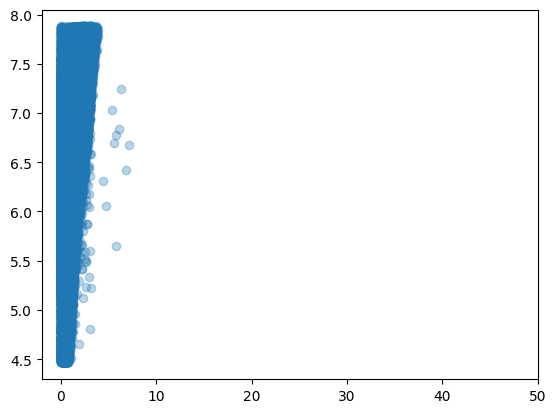

In [195]:
plt.scatter(data['haversine'], data['trip_duration'], alpha=0.3)
plt.xlim(-2, 50)

In [196]:
data = data.drop(columns=['pickup_latitude'])
data = data.drop(columns=['pickup_longitude'])
data = data.drop(columns=['dropoff_latitude'])
data = data.drop(columns=['dropoff_longitude'])
data = data.drop(columns=['id'])
data

,trip_duration,month_1,month_2,month_3,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,morning,day,evening,night,haversine
0,6.739337,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0.816775
1,6.909753,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1.758551
2,6.955593,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,2.136660
3,6.665684,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1.491751
4,6.597146,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1.247339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,7.156177,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1.842198
1021046,6.726233,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.023810
1021047,7.159292,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2.129143
1021048,5.966147,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.496047


In [197]:
data['haversine'].corr(data['trip_duration'])

0.75217077151198

# Разбиение данных и подбор модели

In [198]:
Y = data['trip_duration']
X = data.drop(columns=['trip_duration'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=52)


ridge_params = {'alpha': np.logspace(-3, 2, 10)}
lasso_params = {'alpha': np.logspace(-3, 2, 10)}
ridge = Ridge()
ridge_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_search.fit(X_train, Y_train)
ridge_best = ridge_search.best_estimator_


lasso = Lasso()
lasso_search = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_search.fit(X_train, Y_train)
lasso_best = lasso_search.best_estimator_


for model, name in zip([LinearRegression(), ridge_best, lasso_best], ['Linear', 'Ridge', 'Lasso']):
    model.fit(X_train, Y_train)
    result = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, result))
    print(f'RMSE for {name}: {rmse:.4f}')


RMSE for Linear: 0.4310
RMSE for Ridge: 0.4310
RMSE for Lasso: 0.4311


Мы видим, что разные модели дали примерно одинаковый результат, поэтому я решил оставить Ridge

# Подготавливаем тестовые данные

In [199]:

test = test.drop(columns="vendor_id")
test = test.drop(columns="passenger_count")
test = test.drop(columns="store_and_fwd_flag")
test['pickup_datetime'] = pandas.to_datetime(test['pickup_datetime'])

test['month'] = test['pickup_datetime'].dt.month
test = pandas.get_dummies(test, columns=['month'], prefix='month')

test['day_of_week'] = test['pickup_datetime'].dt.day_of_week
test = pandas.get_dummies(test, columns=['day_of_week'], prefix='day_of_week')
test = test.astype({col: 'int' for col in test.select_dtypes(include='bool').columns})

test['hour'] = test['pickup_datetime'].dt.hour

test['morning'] = test['hour'].between(6, 12).astype(int)
test['day'] = test['hour'].between(13, 17).astype(int)
test['evening'] = test['hour'].between(18, 23).astype(int)
test['night'] = test['hour'].between(0, 5).astype(int)

test = test.drop(columns=['hour'])
test = test.drop(columns=['pickup_datetime'])

test['haversine'] = test.apply(lambda row: haversine((row['pickup_latitude'], row['pickup_longitude']), 
                                                     (row['dropoff_latitude'], row['dropoff_longitude']), 
                                                     unit=Unit.KILOMETERS), axis=1)
test['haversine'] = np.log(test['haversine'] + 1)
answer = pandas.DataFrame()
answer['id'] = test['id']

test = test.drop(columns=['pickup_latitude'])
test = test.drop(columns=['pickup_longitude'])
test = test.drop(columns=['dropoff_latitude'])
test = test.drop(columns=['dropoff_longitude'])
test = test.drop(columns=['id'])

test

,month_1,month_2,month_3,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,morning,day,evening,night,haversine
0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1.325231
1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1.084913
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0.877456
3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1.091474
4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,3.083641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437589,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1.157413
437590,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1.050725
437591,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0.860608
437592,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.622304


In [200]:

answer['trip_duration'] = np.exp(ridge_search.predict(test)) + 1
answer

,id,trip_duration
0,id2793718,773.121418
1,id3485529,519.651029
2,id1816614,341.763524
3,id1050851,688.357142
4,id0140657,4188.918832
...,...,...
437589,id2411525,722.524620
437590,id3782154,559.915206
437591,id0699942,501.447666
437592,id3422152,761.628395


In [201]:
answer.to_csv("answer.csv", index=False)